# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

## Start

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [ ]:
rcParams['figure.figsize'] = 15, 8
mpl.style.use(['ggplot'])
warnings.filterwarnings("ignore")

In [ ]:
df_book = pd.read_csv('https://drive.google.com/uc?id=1O2bTeIIj1FzAqqavKhFoCrNkxx_OEbaq', encoding="ISO-8859-1")
df_book.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [ ]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df_book["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df_book["flight_day"] = df_book["flight_day"].map(mapping)

In [ ]:
df_book["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
df_book.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [ ]:
df_book.shape

(50000, 14)

## Exploratory Data Analysis (Cont)

Split the column which contain number or object

In [ ]:
number_column = []
object_column = []

for i in range(0, len(df_book.columns)):
  if (df_book.dtypes.iloc[i] != 'object'):
    number_column.append(df_book.columns[i])
  else:
    object_column.append(df_book.columns[i])

print(number_column)
print(object_column)

['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']
['sales_channel', 'trip_type', 'route', 'booking_origin']


In [ ]:
df_book[object_column].nunique()

,0
sales_channel,2
trip_type,3
route,799
booking_origin,104


### Numbers

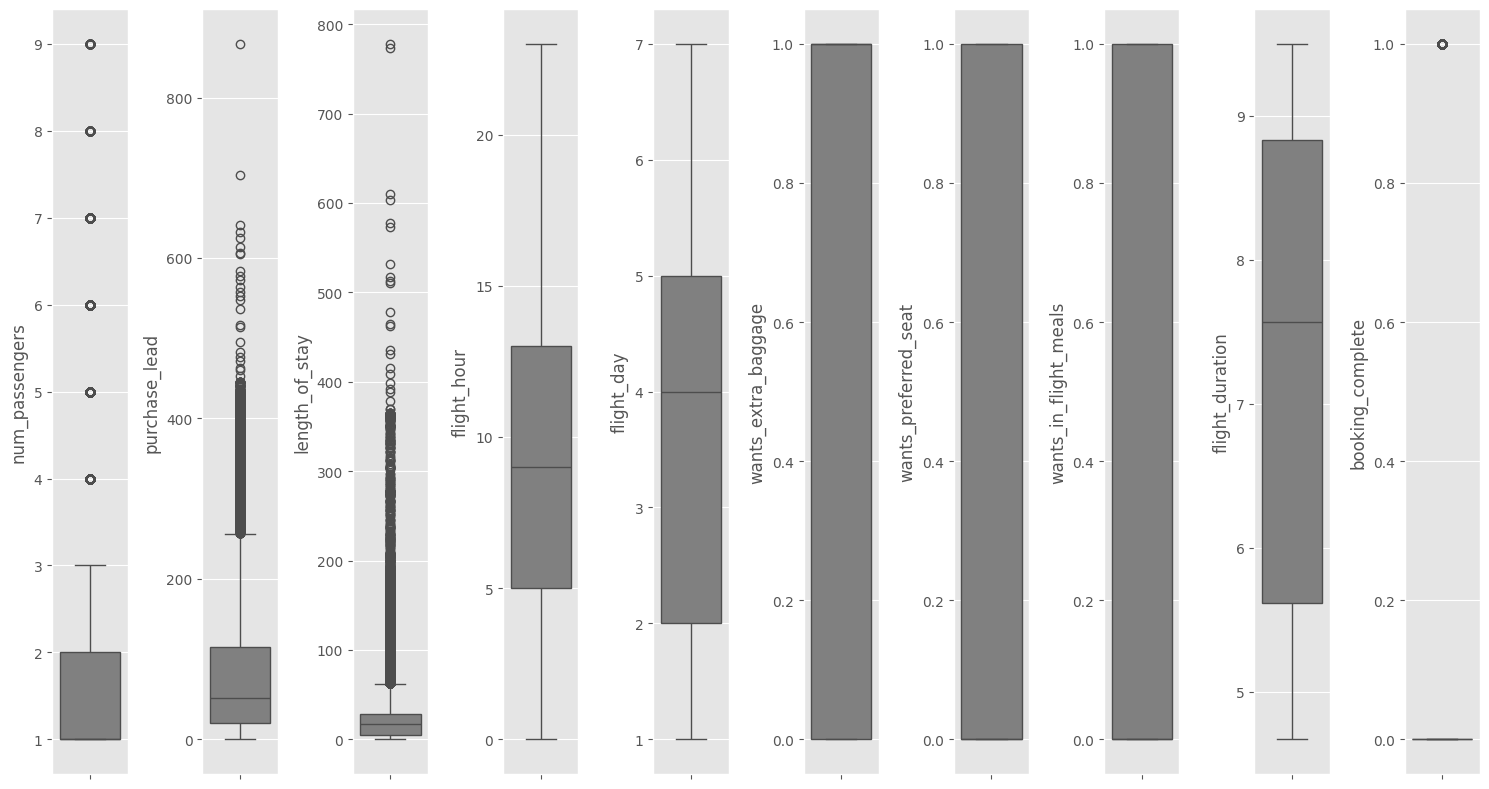

In [ ]:
for i in range(0, len(number_column)):
    plt.subplot(1, len(number_column), i+1)
    sns.boxplot(y=df_book[number_column[i]], color='gray', orient='v')
    plt.tight_layout()

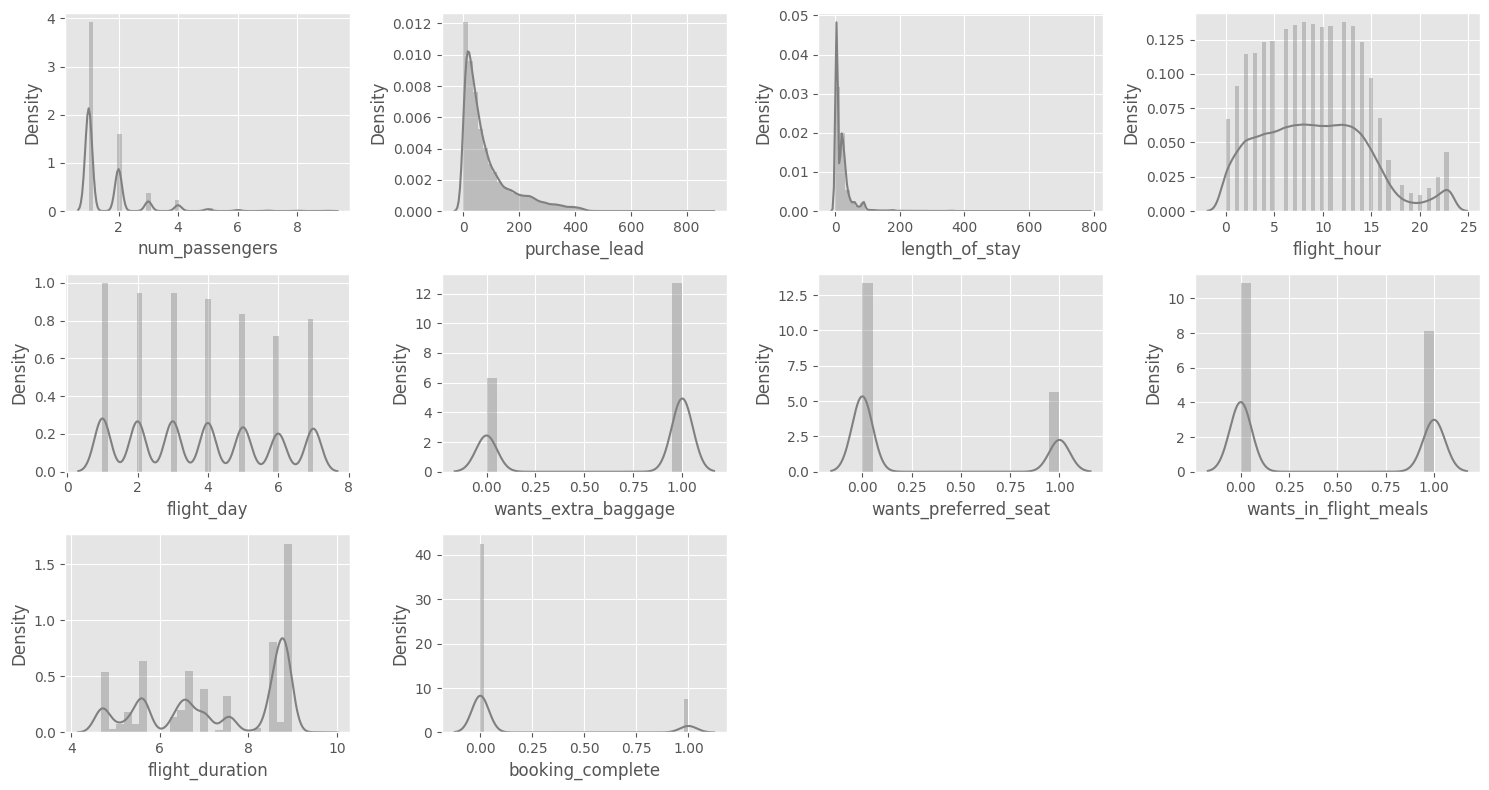

In [ ]:
for i in range(0, len(number_column)):
    plt.subplot(3, 4, i+1)
    sns.distplot(df_book[number_column[i]], color='gray')
    plt.tight_layout()

### Objects

In [ ]:
df_book['route'].value_counts()

,count
route,
AKLKUL,2680
PENTPE,924
MELSGN,842
ICNSIN,801
DMKKIX,744
...,...
LBUTPE,1
CXRMEL,1
DELKBR,1


In [ ]:
df_book['booking_origin'].value_counts().head()

,count
booking_origin,
Australia,17872
Malaysia,7174
South Korea,4559
Japan,3885
China,3387


In [ ]:
object_column

['sales_channel', 'trip_type', 'route', 'booking_origin']

In [ ]:
df_book['sales_channel'].value_counts()

,count
sales_channel,
Internet,44382
Mobile,5618


In [ ]:
df_book['trip_type'].value_counts()

,count
trip_type,
RoundTrip,49497
OneWay,387
CircleTrip,116


## Preparation

### Outlier Handling

Change the outlier value equal to the upper bound

In [ ]:
number_column[:3]

['num_passengers', 'purchase_lead', 'length_of_stay']

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1_np = df_book['num_passengers'].quantile(0.25)
Q3_np = df_book['num_passengers'].quantile(0.75)
IQR_np = Q3_np - Q1_np

Q1_pl = df_book['purchase_lead'].quantile(0.25)
Q3_pl = df_book['purchase_lead'].quantile(0.75)
IQR_pl = Q3_pl - Q1_pl

Q1_ls = df_book['length_of_stay'].quantile(0.25)
Q3_ls = df_book['length_of_stay'].quantile(0.75)
IQR_ls = Q3_ls - Q1_ls

In [ ]:
# Calculate lower and upper bounds for outliers
upper_bound_np = Q3_np + 1.5 * IQR_np
upper_bound_pl = Q3_pl + 1.5 * IQR_pl
upper_bound_ls = Q3_ls + 1.5 * IQR_ls

print(upper_bound_np)
print(upper_bound_pl)
print(upper_bound_ls)

3.5
256.0
62.5


In [ ]:
df_book['num_passengers'][df_book['num_passengers'] > upper_bound_np] = upper_bound_np
df_book['purchase_lead'][df_book['purchase_lead'] > upper_bound_pl] = upper_bound_pl
df_book['length_of_stay'][df_book['length_of_stay'] > upper_bound_ls] = upper_bound_ls

### Object Transformation

Transform the object to number

In [ ]:
object_column

['sales_channel', 'trip_type', 'route', 'booking_origin']

In [ ]:
mapping2 = {
    "OneWay": 1,
    "RoundTrip": 2,
    "CircleTrip": 3
}

df_book["trip_type"] = df_book["trip_type"].map(mapping2)
df_book['trip_type'].sample(5)

,trip_type
39006,2
3206,2
34596,2
12801,2
9916,2


In [ ]:
mapping3 = {
    "Internet" : 1,
    "Mobile" : 0
}

df_book["sales_channel"] = df_book["sales_channel"].map(mapping3)
df_book['sales_channel'].sample(5)

,sales_channel
46344,1
13378,1
12092,1
29960,1
33277,1


In [ ]:
new_booking_origin = np.where((df_book['booking_origin'] == "Australia") | (df_book['booking_origin'] == "Malaysia"), 1, 0)
df_book['booking_origin'] = new_booking_origin
df_book['booking_origin'].sample(5)

,booking_origin
42816,0
21528,1
4475,0
42197,1
22603,1


In [ ]:
df_book.drop(columns=['route'], inplace=True)
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  float64
 1   sales_channel          50000 non-null  int64  
 2   trip_type              50000 non-null  int64  
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  float64
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  int64  
 7   booking_origin         50000 non-null  int64  
 8   wants_extra_baggage    50000 non-null  int64  
 9   wants_preferred_seat   50000 non-null  int64  
 10  wants_in_flight_meals  50000 non-null  int64  
 11  flight_duration        50000 non-null  float64
 12  booking_complete       50000 non-null  int64  
dtypes: float64(3), int64(10)
memory usage: 5.0 MB


### Scaling

Because we want to use KNN

In [ ]:
scaler= MinMaxScaler()
scale_df = scaler.fit_transform(df_book)
scale_df

array([[0.4       , 1.        , 0.5       , ..., 0.        , 0.17598344,
        0.        ],
       [0.        , 1.        , 0.5       , ..., 0.        , 0.17598344,
        0.        ],
       [0.4       , 1.        , 0.5       , ..., 0.        , 0.17598344,
        0.        ],
       ...,
       [0.        , 1.        , 0.5       , ..., 1.        , 0.19668737,
        0.        ],
       [0.        , 1.        , 0.5       , ..., 1.        , 0.19668737,
        0.        ],
       [0.        , 1.        , 0.5       , ..., 0.        , 0.19668737,
        0.        ]])

In [ ]:
df_scale = pd.DataFrame(scale_df, index=df_book.index, columns=df_book.columns)
df_scale.sample(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
17111,0.4,1.0,0.5,1.000000,0.288,0.347826,0.000000,0.0,1.0,0.0,0.0,0.000000,1.0
18542,0.0,1.0,0.5,0.062500,0.720,0.043478,0.000000,0.0,1.0,0.0,0.0,0.861284,1.0
18131,0.8,1.0,0.5,0.050781,0.736,0.565217,0.000000,1.0,1.0,0.0,1.0,0.861284,0.0
39984,1.0,1.0,0.5,1.000000,0.080,0.478261,0.500000,0.0,0.0,0.0,1.0,0.136646,0.0
16515,0.4,1.0,0.5,0.269531,0.352,0.347826,1.000000,0.0,1.0,0.0,0.0,0.482402,0.0
3680,0.4,1.0,0.5,0.011719,0.352,0.565217,0.666667,1.0,1.0,1.0,1.0,0.196687,0.0
27653,0.4,0.0,0.5,0.082031,0.048,0.130435,0.500000,0.0,1.0,0.0,0.0,0.482402,0.0
39129,0.4,1.0,0.5,0.371094,0.080,1.000000,0.333333,0.0,1.0,0.0,1.0,0.403727,1.0
40261,0.4,1.0,0.5,0.101562,0.080,0.521739,0.333333,0.0,1.0,0.0,0.0,0.482402,0.0
1851,0.0,1.0,0.5,0.273438,0.336,0.434783,0.333333,0.0,1.0,1.0,1.0,0.861284,0.0


### Feature Selection

Pearson Correlation visualization

In [ ]:
df_scale.corr().loc['booking_complete'][:-1]

,booking_complete
num_passengers,0.026057
sales_channel,0.041060
trip_type,0.014296
purchase_lead,-0.024504
length_of_stay,-0.072281
flight_hour,0.007127
flight_day,-0.006986
booking_origin,-0.042382
wants_extra_baggage,0.068139
wants_preferred_seat,0.050116


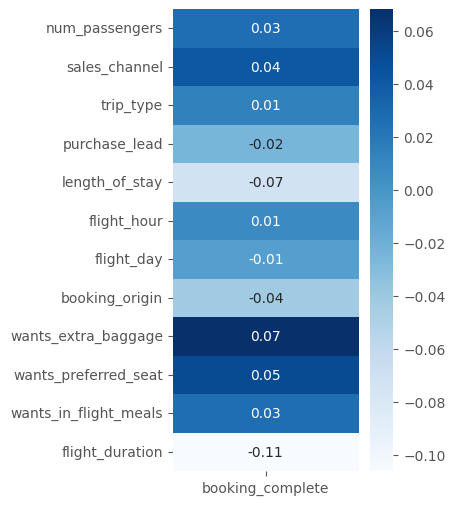

In [ ]:
plt.figure(figsize=(3, 6))
sns.heatmap(pd.DataFrame(df_scale.corr().loc['booking_complete'][:-1]), cmap='Blues', annot=True, fmt='.2f')
plt.show()

### SMOTE Sampling

SMOTE Oversampling to balance the dataset

In [ ]:
df_scale['booking_complete'].value_counts()

,count
booking_complete,
0.0,42522
1.0,7478


In [ ]:
X_sample = df_scale.iloc[:, :-1]
X_sample.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration
0,0.4,1.0,0.5,1.000000,0.304,0.304348,0.833333,0.0,1.0,0.0,0.0,0.175983
1,0.0,1.0,0.5,0.437500,0.320,0.130435,0.833333,0.0,0.0,0.0,0.0,0.175983
2,0.4,1.0,0.5,0.949219,0.352,0.739130,0.333333,0.0,1.0,1.0,0.0,0.175983
3,0.0,1.0,0.5,0.375000,0.496,0.173913,0.833333,0.0,0.0,0.0,1.0,0.175983
4,0.4,1.0,0.5,0.265625,0.352,0.652174,0.333333,0.0,1.0,0.0,1.0,0.175983


In [ ]:
y_sample = df_scale.iloc[:, -1]
y_sample.head()

,booking_complete
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X_sample, y_sample)
y_smote.value_counts()

,count
booking_complete,
0.0,42522
1.0,42522


In [ ]:
new_sample = pd.concat([X_smote, y_smote], axis=1, join='inner')
new_sample.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0.4,1.0,0.5,1.000000,0.304,0.304348,0.833333,0.0,1.0,0.0,0.0,0.175983,0.0
1,0.0,1.0,0.5,0.437500,0.320,0.130435,0.833333,0.0,0.0,0.0,0.0,0.175983,0.0
2,0.4,1.0,0.5,0.949219,0.352,0.739130,0.333333,0.0,1.0,1.0,0.0,0.175983,0.0
3,0.0,1.0,0.5,0.375000,0.496,0.173913,0.833333,0.0,0.0,0.0,1.0,0.175983,0.0
4,0.4,1.0,0.5,0.265625,0.352,0.652174,0.333333,0.0,1.0,0.0,1.0,0.175983,0.0


In [ ]:
new_sample.shape

(85044, 13)

### Feature Selection Part 2

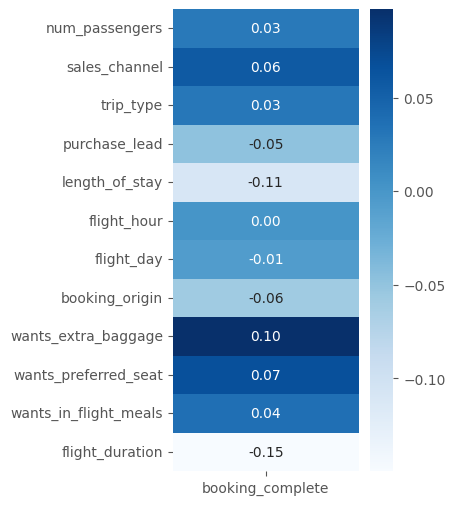

In [ ]:
plt.figure(figsize=(3, 6))
sns.heatmap(pd.DataFrame(new_sample.corr().loc['booking_complete'][:-1]), cmap='Blues', annot=True, fmt='.2f')
plt.show()

In [ ]:
corr_value = pd.DataFrame(new_sample.corr().loc['booking_complete'][:-1].round(2))
corr_value

,booking_complete
num_passengers,0.03
sales_channel,0.06
trip_type,0.03
purchase_lead,-0.05
length_of_stay,-0.11
flight_hour,0.00
flight_day,-0.01
booking_origin,-0.06
wants_extra_baggage,0.10
wants_preferred_seat,0.07


In [ ]:
feature_column = corr_value[(corr_value['booking_complete'] <= -0.05) | (corr_value['booking_complete'] >= 0.05)].index
feature_column = list(feature_column)
feature_column.append('booking_complete')
feature_column

['sales_channel',
 'purchase_lead',
 'length_of_stay',
 'booking_origin',
 'wants_extra_baggage',
 'wants_preferred_seat',
 'flight_duration',
 'booking_complete']

In [ ]:
new_sample = new_sample[feature_column]
new_sample.head()

,sales_channel,purchase_lead,length_of_stay,booking_origin,wants_extra_baggage,wants_preferred_seat,flight_duration,booking_complete
0,1.0,1.000000,0.304,0.0,1.0,0.0,0.175983,0.0
1,1.0,0.437500,0.320,0.0,0.0,0.0,0.175983,0.0
2,1.0,0.949219,0.352,0.0,1.0,1.0,0.175983,0.0
3,1.0,0.375000,0.496,0.0,0.0,0.0,0.175983,0.0
4,1.0,0.265625,0.352,0.0,1.0,0.0,0.175983,0.0


## Modeling

Split X and y to X_train, y_train, X_test, y_test

In [ ]:
X = new_sample.iloc[:, :-1]
X.head()

,sales_channel,purchase_lead,length_of_stay,booking_origin,wants_extra_baggage,wants_preferred_seat,flight_duration
0,1.0,1.000000,0.304,0.0,1.0,0.0,0.175983
1,1.0,0.437500,0.320,0.0,0.0,0.0,0.175983
2,1.0,0.949219,0.352,0.0,1.0,1.0,0.175983
3,1.0,0.375000,0.496,0.0,0.0,0.0,0.175983
4,1.0,0.265625,0.352,0.0,1.0,0.0,0.175983


In [ ]:
y = new_sample.iloc[:, -1]
y.head()

,booking_complete
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, stratify=y)

In [ ]:
knn_non_tuning = KNeighborsClassifier()
knn_non_tuning_acc = cross_val_score(knn_non_tuning, X_train, y_train, scoring="accuracy", cv=10)
print("Each Accuracy = ", knn_non_tuning_acc)
print("Mean = ", knn_non_tuning_acc.mean())

Each Accuracy =  [0.70586259 0.70267092 0.70855031 0.71224593 0.69527969 0.70115908
 0.69813539 0.70855031 0.70418276 0.69259197]
Mean =  0.7029228960188141


In [ ]:
parameters_knn = {
        'n_neighbors' : [3, 5, 7, 9],
        'weights' : ['uniform', 'distance'],
        'metric' : ['euclidean', 'manhattan']
        }

knn_tuning = KNeighborsClassifier()

Estimation: 2.5 minutes

In [ ]:
search_knn = GridSearchCV(knn_tuning,
                        parameters_knn,
                        scoring='accuracy',
                        cv = 10,
                        verbose=3)
search_knn.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.715 total time=   1.0s
[CV 2/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.712 total time=   0.9s
[CV 3/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.711 total time=   1.0s
[CV 4/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.720 total time=   0.9s
[CV 5/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.706 total time=   1.1s
[CV 6/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.713 total time=   1.5s
[CV 7/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.701 total time=   1.1s
[CV 8/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.710 total time=   0.8s
[CV 9/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.711 total time=   0.9s
[CV 10/10] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [ ]:
knn_best_acc_score = search_knn.best_score_
knn_best_parameter = search_knn.best_params_
print("Best Accuracy = ", knn_best_acc_score)
print("Best Parameter = ", knn_best_parameter)

Best Accuracy =  0.7389719469175204
Best Parameter =  {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}


In [ ]:
knn_tuning = KNeighborsClassifier(**knn_best_parameter)
knn_tuning_acc = cross_val_score(knn_tuning, X_train, y_train, scoring="accuracy", cv=10)
print("Each Accuracy = ", knn_tuning_acc)
print("Mean = ", knn_tuning_acc.mean())

Each Accuracy =  [0.74113892 0.74013103 0.74248278 0.74651436 0.73542752 0.73996304
 0.73794725 0.73374769 0.74046699 0.73189988]
Mean =  0.7389719469175204


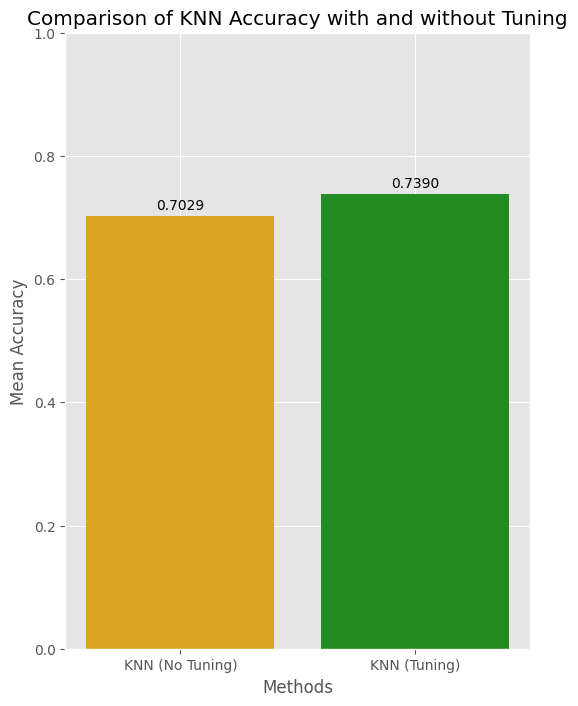

In [ ]:
# Data for the plot
knn_non_tuning_mean_accuracy = knn_non_tuning_acc.mean()
knn_tuning_mean_accuracy = knn_tuning_acc.mean()

methods = ['KNN (No Tuning)', 'KNN (Tuning)']
accuracies = [knn_non_tuning_mean_accuracy, knn_tuning_mean_accuracy]

# Create the bar plot
plt.figure(figsize=(6, 8))
plt.bar(methods, accuracies, color=['goldenrod', 'forestgreen'])
plt.xlabel('Methods')
plt.ylabel('Mean Accuracy')
plt.title('Comparison of KNN Accuracy with and without Tuning')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy

# Add accuracy values on top of each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.show()


## Evaluation

In [ ]:
knn_tuning.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')

In [ ]:
knn_val = knn_tuning.predict(X_train)
print("Accuracy : ", metrics.accuracy_score(y_train, knn_val))
print("Precision: ", metrics.precision_score(y_train, knn_val))
print("Recall   : ", metrics.recall_score(y_train, knn_val))
print("F1 Score : ", metrics.f1_score(y_train, knn_val))

Accuracy :  0.9770031916680665
Precision:  0.9956017872102765
Recall   :  0.9582395430875189
F1 Score :  0.9765634362213891


[Text(0, 0.5, '1'), Text(0, 1.5, '0')]

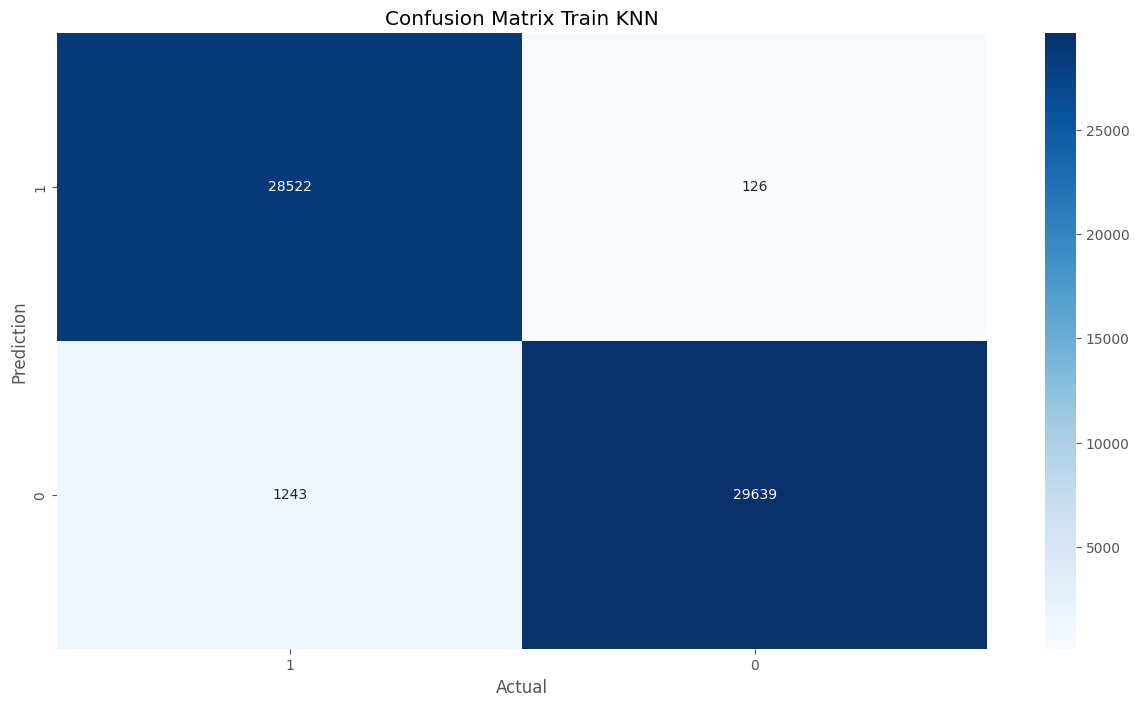

In [ ]:
cf_matrix = metrics.confusion_matrix(y_train, knn_val, labels=[1,0]).transpose()

plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Actual')
ax.set_ylabel('Prediction')
ax.set_title('Confusion Matrix Train KNN')
ax.xaxis.set_ticklabels(['1', '0'])
ax.yaxis.set_ticklabels(['1', '0'])

In [ ]:
knn_prediction = knn_tuning.predict(X_test)
print("Accuracy : ", metrics.accuracy_score(y_test, knn_prediction))
print("Precision: ", metrics.precision_score(y_test, knn_prediction))
print("Recall   : ", metrics.recall_score(y_test, knn_prediction))
print("F1 Score : ", metrics.f1_score(y_test, knn_prediction))

Accuracy :  0.7428470643568237
Precision:  0.7719452247191011
Recall   :  0.6893470251626558
F1 Score :  0.7283117313346308


[Text(0, 0.5, '1'), Text(0, 1.5, '0')]

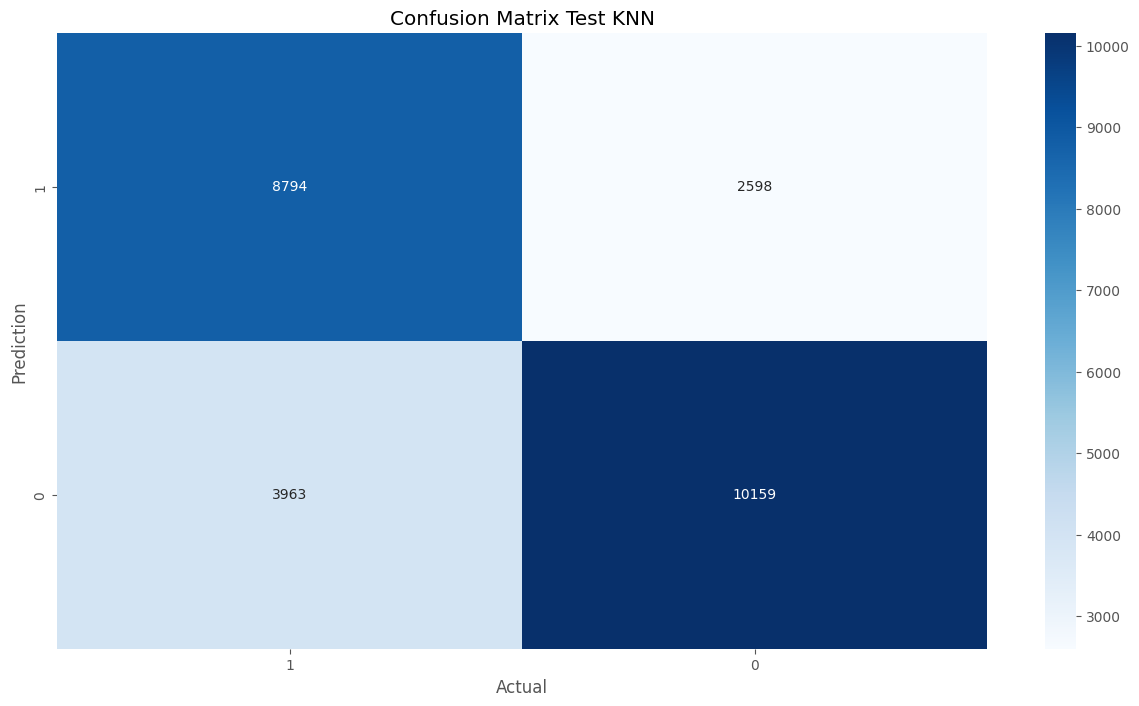

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test, knn_prediction, labels=[1,0]).transpose()

plt.figure(figsize=(15,8))
ax = plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Actual')
ax.set_ylabel('Prediction')
ax.set_title('Confusion Matrix Test KNN')
ax.xaxis.set_ticklabels(['1', '0'])
ax.yaxis.set_ticklabels(['1', '0'])